In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
from pprint import pprint
from typing import Dict

In [16]:
import sys
sys.path.append("../")

In [20]:
import constants
from core.tools.metrics import *
from core.tools.visualize import *
from core.tools.time_series import *
from core.tools.data_import import *
import core.tools.rnn_prepare as rnn_prepare

In [21]:
# Load the model
import core.models.stacked_lstm as stacked_lstm

In [22]:
# Avaiable datasets, loaded from constants.
pprint(constants.DATA_DIR)
choice = None
while choice is None or choice not in constants.DATA_DIR.keys():
    if choice is not None:
        print("Invalid data location received, try again...")
    choice = input("Select Dataset >>> ")
FILE_DIR = constants.DATA_DIR[choice]

{'0': '/Users/tianyudu/Documents/Academics/EconForecasting/AnnEconForecast/data/UNRATE.csv',
 '1': '/home/ec2-user/AnnEconForecast/data/UNRATE.csv',
 '2': '/home/ubuntu/AnnEconForecast/data/UNRATE.csv',
 '3': '/home/ec2-user/AnnEconForecast/data/DEXCAUS.csv'}
Select Dataset >>> 0


In [23]:
print(f"Dataset chosen: \n{FILE_DIR}")

Dataset chosen: 
/Users/tianyudu/Documents/Academics/EconForecasting/AnnEconForecast/data/UNRATE.csv


In [24]:
# Pre-processing Parameters
PERIODS = 1
ORDER = 1
LAGS = 12
TRAIN_RATIO = 0.8

In [25]:
# # Neural Network Parameters
# NUM_TIME_STEPS = LAGS
# # Number of series used to predict. (including concurrent)
# NUM_INPUTS = 1
# NUM_OUTPUTS = 1
# NUM_NEURONS = 64
# # Number of output series
# LEARNING_RATE = 0.01
# EPOCHS = 50
# # Training Settings
# REPORT_PERIODS = 1
# TENSORBOARD_DIR = "./tensorboard/test/1"

In [26]:
EXPERIMENT_NAME = "local-demo"

In [27]:
# Main Training Parameters
parameters = {
    "epochs": 250,
    "num_time_steps": LAGS,
    "num_inputs": 1,
    "num_outputs": 1,
    "num_neurons": (128, 64),
    "learning_rate": 0.01,
    "report_periods": 10,
    "tensorboard_dir": f"/Users/tianyudu/Documents/Academics/EconForecasting/AnnEconForecast/tensorboard/{EXPERIMENT_NAME}",
    "model_path": f"/Users/tianyudu/Desktop/{EXPERIMENT_NAME}/my_model"
}

In [30]:
prepared_df = rnn_prepare.prepare_dataset(
    file_dir=FILE_DIR,
    periods=PERIODS,
    order=ORDER
)

Retrieving raw data from /Users/tianyudu/Documents/Academics/EconForecasting/AnnEconForecast/data/UNRATE.csv...
Dataset loaded.    
	Index type: datetime64[ns]    
	Data type: float64
Processing data, taking (periods, order)=(1, 1)...
Dropping Nan observations...
First few rows of dataset loaded:
            UNRATE_period1_order1
DATE                             
1948-02-01                    0.4
1948-03-01                    0.2
1948-04-01                   -0.1
1948-05-01                   -0.4
1948-06-01                    0.1


In [34]:
# Normalize data
(X_train, X_val, X_test,
 y_train, y_val, y_test) = rnn_prepare.generate_splited_dataset(
    raw=prepared_df,
    train_ratio=0.7,
    val_ratio=0.15,
    lags=LAGS
)

Scaling based on the first 594 observations.
Total 836 observations generated.
Note: shape format: (num_obs, time_steps, num_inputs/outputs)
X shape = (836, 12, 1), y shape = (836, 1, 1)
Training and testing set generated,        
X_train shape: (584, 12, 1)        
y_train shape: (584, 1)        
X_test shape: (126, 12, 1)        
y_test shape: (126, 1)        
X_validation shape: (126, 12, 1)        
y_validation shape: (126, 1)


In [35]:
data_collection = {
    "X_train": X_train,
    "X_val": X_val,
    "X_test": X_test,
    "y_train": y_train,
    "y_val": y_val,
    "y_test": y_test
}

In [36]:
checkpoints = lambda z: [z*x for x in range(1, parameters["epochs"] // z)] + [-1]

In [37]:
# Run the model
(metrics_dict, predictions) = stacked_lstm.exec_core(
    parameters=parameters,
    data_collection=data_collection,
    clip_grad=None,
    prediction_checkpoints=checkpoints(50)
)

Resetting Tensorflow defalut graph...
Note: no gradient clipping is applied.            
If possible gradient exploding detected (e.g. nan loss), try use clip_grad.

Iteration [0], Training MSE 35.9909592; Validation MSE 14.3531790

Iteration [100], Training MSE 0.7350329; Validation MSE 0.2807418

Iteration [200], Training MSE 0.4403983; Validation MSE 0.2960426
Saving the trained model...
Time taken for [250] epochs:  0:00:36.100661
Loss Summary:
	mae=0.6807021498680115
	mse=0.7543657422065735
	rmse=0.8685423135757446
	mape=11.744568824768066


In [18]:
# plt.close()
# plt.figure(figsize=(32, 16))
# plt.plot(predictions[1000]["train"].reshape(-1, 1), alpha=0.6)
# plt.plot(y_train.reshape(-1, 1), alpha=0.6)
# plt.legend(["Training Prediction", "Training Actual"])
# plt.grid(True)
# plt.title("Training Set Result")
# plt.show()

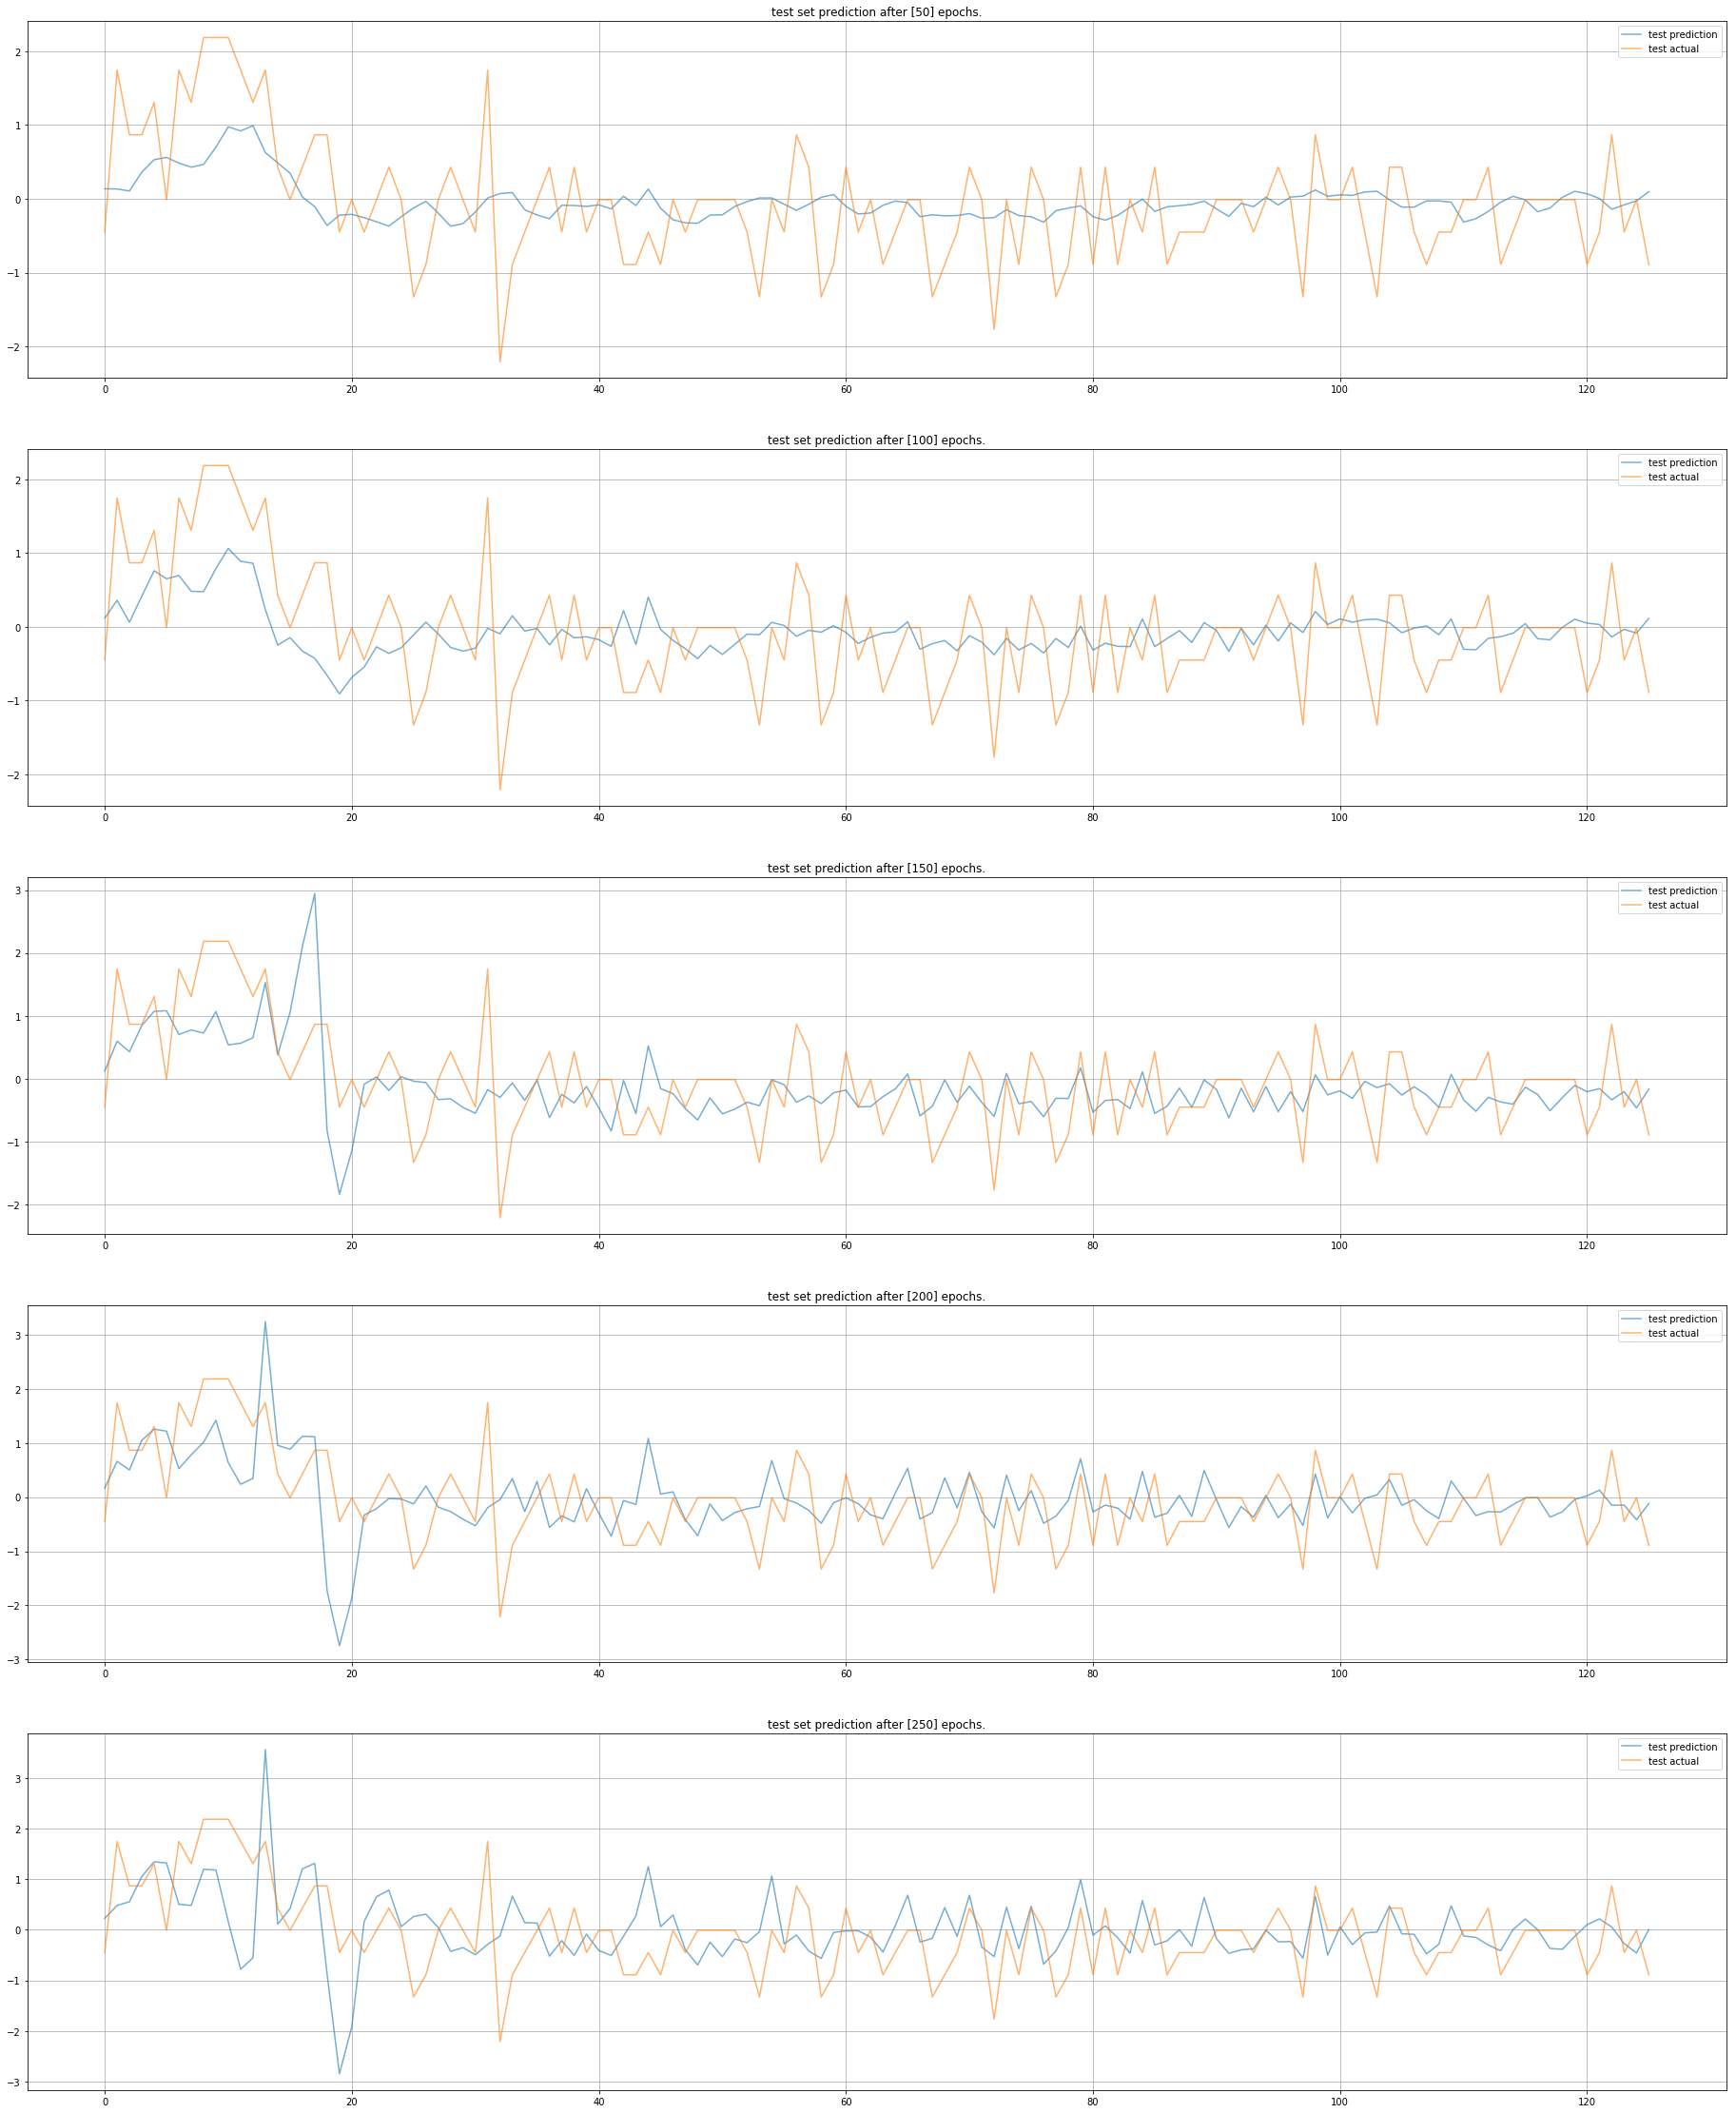

In [39]:
fig = plot_checkpoints(predictions, y_test, "test")

In [17]:
# plt.close()
# plt.figure(figsize=(32, 16))
# plt.plot(predictions[100]["test"].reshape(-1, 1), alpha=0.6)
# plt.plot(y_test.reshape(-1, 1), alpha=0.6)
# plt.legend(["Testing Prediction", "Testing Actual"])
# plt.grid(True)
# plt.title("Testing Set Result")
# plt.show()